# Business Intelligence per Big Data
#### Davide Leo (300890)
#### Emanuele Pinna (296455)

Il dataset che verrà analizzato è una raccolta di recensioni di prodotti venduti su Amazon appartenenti a quattro differenti categorie:
1. cd e vinili;
2. casa e cucina;
3. video games;
4. kindle store.

L'analisi consta di $4$ procedure principali, ovvero:
1. data cleaning;
2. analisi statistica;
3. clustering;
4. classificazione.

## Data cleaning
Si comincia importando il dataset.

In [1]:
import pandas as pd

data = pd.read_csv('dataset6.csv')
data.head()

reviewerID        asin         reviewerName helpful  \
0   AH9396O3FGHZF  B000P2A242  T A Shepherd tas50l  [3, 6]   
1  A39GW5CBWTIWAZ  B000852G2C               Phil S  [0, 0]   
2   AW0K56SPCD5XK  B0001F7UHA  ladevine1 ladevine1  [0, 0]   
3  A2YKADCJME4FSW  B00E5XLZM0      Tom Birkenstock  [5, 5]   
4   AH09XLCE12IO7  B00026WV9U           M Anderson  [1, 2]   

                                          reviewText  overall  \
0  No matter how many times Paul McCartney shifts...      4.0   
1  With all due respect and all that good stuf th...      5.0   
2  This CD is incredible This is indeed to date U...      4.0   
3  When was the last time you heard a drum solo o...      4.0   
4  This is a good release the best of the AI gang...      4.0   

                      summary  unixReviewTime   reviewTime  label  
0          No mediocrity here      1182124800  06 18, 2007      1  
1  5 stars for Disc Two alone      1225670400   11 3, 2008      1  
2                        Yeah      1087776000  06 21, 2004      1  
3        Classic Rock in 2013      1388275200  12 29, 2013      1  
4                 Good Ol Pop      1097798400  10 15, 2004      1

Si effettua quindi un controllo sulla presenza di eventuali missing values.

In [2]:
# Si genera un dizionario le cui chiavi saranno i nomi delle colonne
# del dataset, mentre gli argomenti il numero di missing values relativo
# alla colonna analizzata
mv_dict = dict()
n_rows = data.shape[0]

for col in data.columns:
    for i,idx in zip(data[col].isnull(),range(n_rows)):
        if i == True:
            if col not in mv_dict:
                mv_dict[col] = [idx]
            else:
                mv_dict[col].append(idx)
    if col in mv_dict:
        print('La colonna ', col, ' contiene', len(mv_dict[col]), ' missing values.')

La colonna  reviewerName  contiene 28  missing values.
La colonna  reviewText  contiene 2  missing values.
La colonna  summary  contiene 3  missing values.


La colonna *reviewerName* genera ridondanza poiché gli utenti sono già identificati dai rispettivi *id*.

In [3]:
print('summary indexes: ',mv_dict['summary'],
     '\nreviewText indexes: ',mv_dict['reviewText'])

summary indexes:  [1242, 3507, 3734] 
reviewText indexes:  [80, 1319]


Gli indici delle righe corrispondenti ai missing values non coincidono, per cui, le recensioni mancanti possono essere sostituite dai rispettivi *summary* e viceversa. Prima di effettuare qualsiasi modifica si genera una copia del dataset.

In [4]:
data_mod = data.copy()

# Eliminazione della colonna reviewerName 
data_mod.drop(columns = 'reviewerName', inplace = True)

# Sostituzione dei reviewText e summary mancanti 
data_mod.loc[mv_dict['reviewText'],'reviewText'] = data_mod.loc[mv_dict['reviewText'],'summary']
data_mod.loc[mv_dict['summary'],'summary'] = data_mod.loc[mv_dict['summary'],'reviewText']

data_mod.shape

(4000, 9)

L'attributo *helpful* è costituito da due componenti, ovvero:
1. il numero di volte totale in cui la recensione è stata valutata utile;
2. il numero di volte totale in cui la recensione è stata valutata.

Risulta quindi utile dividere provvisoriamente la colonna rispettivamente in *helpfulVote* e *vote*.

In [5]:
votes = [0]*n_rows
helps = [0]*n_rows
for vote,idx in zip(data_mod['helpful'],range(n_rows)):
    v_str = ''
    h_str = ''
    flag = 0
    for c in vote:
        if c not in ['[', ' ', ','] and flag == 0:
            h_str += c
        elif c == ',':
            flag = 1
        elif c not in [']', ' ', ','] and flag == 1:
            v_str += c
    votes[idx] = int(v_str)
    helps[idx] = int(h_str)
data_mod.drop('helpful', axis=1, inplace=True)
data_mod['vote'] = votes
data_mod['helpfulVote'] = helps

data_mod.head()

reviewerID        asin  \
0   AH9396O3FGHZF  B000P2A242   
1  A39GW5CBWTIWAZ  B000852G2C   
2   AW0K56SPCD5XK  B0001F7UHA   
3  A2YKADCJME4FSW  B00E5XLZM0   
4   AH09XLCE12IO7  B00026WV9U   

                                          reviewText  overall  \
0  No matter how many times Paul McCartney shifts...      4.0   
1  With all due respect and all that good stuf th...      5.0   
2  This CD is incredible This is indeed to date U...      4.0   
3  When was the last time you heard a drum solo o...      4.0   
4  This is a good release the best of the AI gang...      4.0   

                      summary  unixReviewTime   reviewTime  label  vote  \
0          No mediocrity here      1182124800  06 18, 2007      1     6   
1  5 stars for Disc Two alone      1225670400   11 3, 2008      1     0   
2                        Yeah      1087776000  06 21, 2004      1     0   
3        Classic Rock in 2013      1388275200  12 29, 2013      1     5   
4                 Good Ol Pop      1097798400  10 15, 2004      1     2   

   helpfulVote  
0            3  
1            0  
2            0  
3            5  
4            1

Procedendo con la riformattazione del dataset, si controllano i valori delle valutazioni dei vari prodotti.

In [6]:
data_mod['overall'].value_counts()

5.0    2327
4.0     912
3.0     402
2.0     187
1.0     172
Name: overall, dtype: int64

Si envice dall'output del *value_counts* il forte sbilanciamento del dataset rispetto a questo attributo. Per il momento ci si sofferma ai valori che la variabile può assumere. Si procederà con un casting nel tipo *intero*.

In [7]:
overall = [None]*n_rows
for rate,idx in zip(data_mod['overall'], range(n_rows)):
    overall[idx] = int(rate)
data_mod['overall'] = overall
    
data_mod.head()

reviewerID        asin  \
0   AH9396O3FGHZF  B000P2A242   
1  A39GW5CBWTIWAZ  B000852G2C   
2   AW0K56SPCD5XK  B0001F7UHA   
3  A2YKADCJME4FSW  B00E5XLZM0   
4   AH09XLCE12IO7  B00026WV9U   

                                          reviewText  overall  \
0  No matter how many times Paul McCartney shifts...        4   
1  With all due respect and all that good stuf th...        5   
2  This CD is incredible This is indeed to date U...        4   
3  When was the last time you heard a drum solo o...        4   
4  This is a good release the best of the AI gang...        4   

                      summary  unixReviewTime   reviewTime  label  vote  \
0          No mediocrity here      1182124800  06 18, 2007      1     6   
1  5 stars for Disc Two alone      1225670400   11 3, 2008      1     0   
2                        Yeah      1087776000  06 21, 2004      1     0   
3        Classic Rock in 2013      1388275200  12 29, 2013      1     5   
4                 Good Ol Pop      1097798400  10 15, 2004      1     2   

   helpfulVote  
0            3  
1            0  
2            0  
3            5  
4            1

Le *label* dovranno essere invece riformattate come stringhe poiché sono variabili categoriche e non intere. Successivamente verrà applicato un One-Hot-Encoding per la costruzione dei modelli di clustering e classificazione.

In [8]:
labels = [None]*n_rows
for lab,idx in zip(data_mod['label'], range(n_rows)):
    labels[idx] = int(lab)
data_mod['label'] = labels
    
data_mod.head()

reviewerID        asin  \
0   AH9396O3FGHZF  B000P2A242   
1  A39GW5CBWTIWAZ  B000852G2C   
2   AW0K56SPCD5XK  B0001F7UHA   
3  A2YKADCJME4FSW  B00E5XLZM0   
4   AH09XLCE12IO7  B00026WV9U   

                                          reviewText  overall  \
0  No matter how many times Paul McCartney shifts...        4   
1  With all due respect and all that good stuf th...        5   
2  This CD is incredible This is indeed to date U...        4   
3  When was the last time you heard a drum solo o...        4   
4  This is a good release the best of the AI gang...        4   

                      summary  unixReviewTime   reviewTime  label  vote  \
0          No mediocrity here      1182124800  06 18, 2007      1     6   
1  5 stars for Disc Two alone      1225670400   11 3, 2008      1     0   
2                        Yeah      1087776000  06 21, 2004      1     0   
3        Classic Rock in 2013      1388275200  12 29, 2013      1     5   
4                 Good Ol Pop      1097798400  10 15, 2004      1     2   

   helpfulVote  
0            3  
1            0  
2            0  
3            5  
4            1

Per concludere la riformattazione degli attributi, è possibile osservare che sono presenti due rappresentazioni alternative del tempo. In generale, il *UnixTime* rappresenta il tempo come il numero di secondi trascorsi a partire dal $1^o$ Gennaio 1970 UTC. 

Trattandosi comunque di recensioni di Amazon e non di post su social network, si può assumere, senza perdita di generalità, che la possibilità che alcune recensioni siano correlate tra esse tramite istanti temporali ravvicinati (minuti e secondi) è molto bassa. Per cui si è scelto di definire gli istanti temporali in funzione dei giorni, mesi e anni (ed eventualmente della data nel formato giorno-mese-anno).

In [9]:
from datetime import datetime

data_mod.drop(columns = 'reviewTime', inplace = True)

year = [0]*n_rows
month = [0]*n_rows
day = [0]*n_rows
Date = [0]*n_rows
Date_my = [0]*n_rows

for date,idx in zip(data_mod['unixReviewTime'],range(n_rows)):
    date_tmp = datetime.fromtimestamp(date)
    year[idx] = date_tmp.year
    month[idx] = date_tmp.month
    day[idx] = date_tmp.day

    date = str(date_tmp.year) + '-' + str(date_tmp.month) + '-' + str(date_tmp.day)
    date_my = str(date_tmp.year) + '-' + str(date_tmp.month)
    Date[idx] = datetime.strptime(date, '%Y-%m-%d')
    Date_my[idx] = datetime.strptime(date_my, '%Y-%m')

data_mod.drop('unixReviewTime', axis=1, inplace=True)
data_mod['day'] = day
data_mod['month'] = month
data_mod['year'] = year
data_mod['month-year'] = Date_my
data_mod['Date'] = Date

data_mod.head()

reviewerID        asin  \
0   AH9396O3FGHZF  B000P2A242   
1  A39GW5CBWTIWAZ  B000852G2C   
2   AW0K56SPCD5XK  B0001F7UHA   
3  A2YKADCJME4FSW  B00E5XLZM0   
4   AH09XLCE12IO7  B00026WV9U   

                                          reviewText  overall  \
0  No matter how many times Paul McCartney shifts...        4   
1  With all due respect and all that good stuf th...        5   
2  This CD is incredible This is indeed to date U...        4   
3  When was the last time you heard a drum solo o...        4   
4  This is a good release the best of the AI gang...        4   

                      summary  label  vote  helpfulVote  day  month  year  \
0          No mediocrity here      1     6            3   18      6  2007   
1  5 stars for Disc Two alone      1     0            0    3     11  2008   
2                        Yeah      1     0            0   21      6  2004   
3        Classic Rock in 2013      1     5            5   29     12  2013   
4                 Good Ol Pop      1     2            1   15     10  2004   

  month-year       Date  
0 2007-06-01 2007-06-18  
1 2008-11-01 2008-11-03  
2 2004-06-01 2004-06-21  
3 2013-12-01 2013-12-29  
4 2004-10-01 2004-10-15

Si verifichi adesso che non ci siano dei duplicati nel dataset.

In [10]:
columns = ['reviewText', 'reviewerID','vote', 
           'helpfulVote','year', 'month', 'day', 'summary']
cols = []
for col in columns:
    cols += [col]
    if True in data_mod[cols].duplicated().value_counts():
        print(cols, ': trovati duplicati')

Non sono presenti duplicati nel dataset, per cui si può procedere con la ricerca degli outliers. Principalmente, nel caso di documenti testuali, gli outliers sono rintracciabili negli utenti (bot, spambot, spams) o, nel caso delle recensioni, nell'incompatibilità del rate con il documento di testo. Si procede quindi con un cleaning dei documenti testuali, omogeneizzandoli tutti allo stesso formato, per poi effettuare l'analisi.

In [11]:
import re
import string
import itertools
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def text_cleaning(texts):
    sw = set(stopwords.words('english'))
    lem = WordNetLemmatizer()
    ps = PorterStemmer()
    new_texts = [None]*len(texts)
    for text,i in zip(texts, range(len(texts))):
        # non-printable characters cleaning
        text = ''.join([str(c) for c in text if c in string.printable])
        # upper case cleaning
        text = text.lower()
        # \n cleaning
        text = text.replace('\n', '')
        # URLS cleaning
        text = re.sub(r'http\S+', '', text)
        # www.randomwebsite.com cleaning
        text = ' '.join(item for item in text.split() if not \
                (item.startswith('www.') and item.endswith('.com')))
        # numbers cleaning
        text = ''.join(c for c in text if not c.isdigit())
        # removing punctuation
        for punct in string.punctuation:
            text = text.replace(punct, " ")
        # tokenization
        text = word_tokenize(text)
        # removing stopwords
        for word in sw:
            if word in text:
                text.pop(text.index(word))
        # lemmatization and/or stemming
        text = ' '.join(lem.lemmatize(c) for c in text)
        # text = ' '.join(ps.stem(c) for c in text.split())
        # new data update
        new_texts[i] = text
    return new_texts

data_mod['reviewText'] = text_cleaning(data_mod['reviewText'])
data_mod['summary'] = text_cleaning(data_mod['summary'])

data_mod[['reviewText','summary']].head()

reviewText              summary
0  matter many time paul mccartney shift always c...           mediocrity
1  due respect all good stuf editorial comment in...  star disc two alone
2  cd incredible this is indeed date usher best f...                 yeah
3  last time heard drum solo a new album think dr...         classic rock
4  good release best the ai gang definitely a pop...          good ol pop

In [12]:
null_idx = []

for col in ['reviewText', 'summary']:
    for b,idx in zip(data_mod[col].isnull(),range(n_rows)):
        if b==True:
            null_idx.append(idx)
print(len(null_idx))   

0


Nessuna recensione e nessun summary sono rimasti vuoti.

Si cercano quindi gli utenti che hanno recensito più volte.

In [13]:
data_mod['reviewerID'].value_counts()

A2582KMXLK2P06    6
AJKWF4W7QD4NS     5
A2WQY1B8ZS7QRZ    3
AEC90GPFKLAAW     3
A1BB4H9G9APMT3    3
                 ..
AL1P2XXNHY3UG     1
A3IZ4LHS0G79X7    1
A2IVI08I5ZJ06O    1
ALC8I6BZ0QDJE     1
A14BW8QJ873357    1
Name: reviewerID, Length: 3873, dtype: int64

Già da questo primo risultato si può supporre che i recensori non siano bot o spambot. 

In [14]:
data_mod.loc[data_mod['reviewerID']=='A2582KMXLK2P06','reviewText']

302     begin swift franticpaced acoustic work heavy g...
405     let admit right band isnt thingthe opening son...
926     best way describe casino would like the guitar...
2117    many star fox game released since first one ap...
2335    dont think anyone deny probably best pokemon g...
2473    give donkey kong land rating of ive decided up...
Name: reviewText, dtype: object

In [15]:
data_mod.loc[data_mod['reviewerID']=='AJKWF4W7QD4NS','reviewText']

798     started listening deftones numetal became the ...
2109    wake the revolutionary grand theft auto horde ...
2347    marios first appearance gba came the first sup...
2552    yet another poor xmen game gbc courtesy activi...
2981    brain age offer time around played the origina...
Name: reviewText, dtype: object

Prima di procedere con l'analisi statistica del dataset, si controlli che sia bilanciato rispetto alle *label*.

In [16]:
data_mod['label'].value_counts()

1    1000
2    1000
3    1000
4    1000
Name: label, dtype: int64

## Analisi statistica e bilanciamento del dataset

In primo luogo è utile conoscere il numero complessivo di utenti, prodotti e date distinte, in maniera tale da comprendere quanto queste quantità possano essere informative ed, eventualmente, utili per l'analisi del dataset.

In [17]:
n_ids = len(data_mod['reviewerID'].value_counts().index.tolist())
n_asin = len(data_mod['asin'].value_counts().index.tolist())
n_date = len(data_mod['Date'].value_counts().index.tolist())

print('n_ids: ', n_ids, 
     '\nn_asin: ', n_asin,
     '\nn_date: ', n_date)

n_ids:  3873 
n_asin:  3770 
n_date:  2103


È evidente come, considerando che il dataset è composto da $4000$ record, relativi a singole recensioni, si tratti di attributi poco utili alla nostra analisi, poichè vi sono all'incirca poco più di  $1$ utente ed $1$ prodotto per recensione. Anche la data risulta essere poco informativa, risulta quindi più utile analizzare un range temporale meno specifico.

In [18]:
n_my = len(data_mod['month-year'].value_counts().index.tolist())
n_year = len(data_mod['year'].value_counts().index.tolist())
print('n_month_year: ', n_my, 
     '\nn_year: ', n_year)

n_month_year:  184 
n_year:  17


Si decide quindi di generare una matrice di correlazione al fine di verificare le ipotesi proposte.

Prima di procedere con la vettorizzazione dei testi si vuole analizzare la correlazione tra gli attributi delle recensioni al fine di selezionare e/o, eventualmente, raffinare gli attributi più informativi.

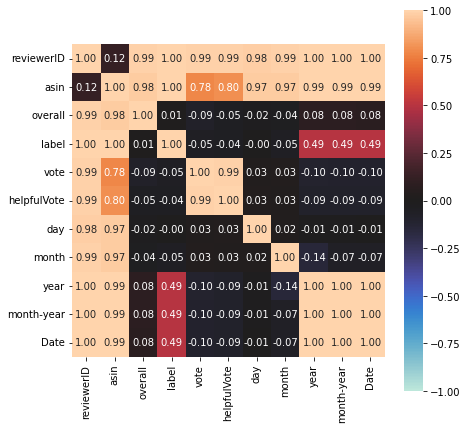

In [19]:
import seaborn as sns
from dython.nominal import associations

data_corr = data_mod.drop(columns = ['reviewText','summary']).copy()

corr_matrix = associations(data_corr, figsize=(7,7), plot = False)
matrix = corr_matrix['corr']

Le dipendenze delle varie variabili temporali rispetto a loro stesse non ci interessano per la nostra analisi.

<AxesSubplot:>

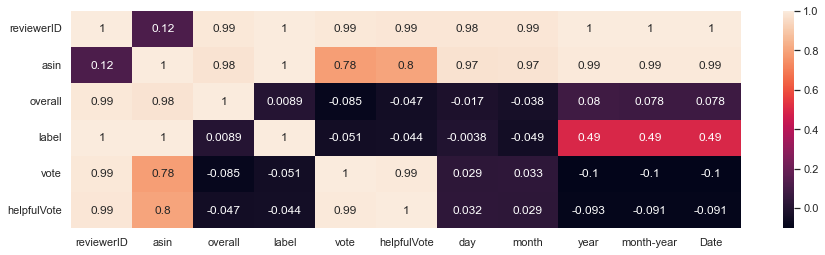

In [20]:
sns.set(rc = {'figure.figsize':(15,4)})
sns.heatmap(matrix.iloc[:6,:], annot=True)

Come ipotizzato, utente e prodotto risultano fortemente correlati con ciascun attributo per via della corrispondenza quasi univoca con la recensione. Le recensioni invece risultano debolmente correlate con il periodo, in cui sono state effettuate; in particolare, si osserva come il dato relativo al singolo anno è correlato agli altri attributi quanto la data nei formati *giorno-mese-anno* e *mese-anno*. Successivamente si condurrà un analisi specifica per comprendere il risultato ottenuto. Un'ultima considerazione riguarda gli attributi *vote* ed *helpfulVote* i quali risultano correlati tra loro stessi. Poiché possono influenzare la scelta di un utente sull'acquisto, condensarli in un unico indice di "utilità" della recensione, probabilmente influenzando in maniera più diretta gli altri attributi.

Poiché in questa prima analisi non si è considerato nulla per quanto riguarda gli effettivi testi delle recensioni, si introduce l'attributo *reviewLen* indicante il numero di caratteri presenti in ogni recensione. 

Prima di eliminare gli attributi relativi all'utente, al prodotto e alla data, si inserisce prima l'attributo *reviewLen* e si uniformano i valori numerici/quantitativi del dataset tramite opportuni riscalamenti.

In [21]:
# costruzione attributo reviewLen
reviewLen = [len(review) for review in data_mod['reviewText']]

# inserimento attributo
data_corr['reviewLen'] = reviewLen

# riordinamento colonne per coerenza di output
columns = data_corr.columns
new_columns = ['reviewerID','asin', 'reviewLen', 'overall']
for col in columns[3:-1]:
    new_columns.append(col)
    
data_corr = data_corr[new_columns].copy()
data_corr.head()

reviewerID        asin  reviewLen  overall  label  vote  helpfulVote  \
0   AH9396O3FGHZF  B000P2A242        620        4      1     6            3   
1  A39GW5CBWTIWAZ  B000852G2C       1697        5      1     0            0   
2   AW0K56SPCD5XK  B0001F7UHA        660        4      1     0            0   
3  A2YKADCJME4FSW  B00E5XLZM0       2071        4      1     5            5   
4   AH09XLCE12IO7  B00026WV9U        270        4      1     2            1   

   day  month  year month-year       Date  
0   18      6  2007 2007-06-01 2007-06-18  
1    3     11  2008 2008-11-01 2008-11-03  
2   21      6  2004 2004-06-01 2004-06-21  
3   29     12  2013 2013-12-01 2013-12-29  
4   15     10  2004 2004-10-01 2004-10-15

La matrice di correlazione costruita in precedenza potrebbe presentare correlazioni "non rappresentative" per il semplice motivo che i dati non sono ancora stati sottoposti ad alcun tipo di bilanciamento e riscalamento. Si procede quindi con un'analisi degli attributi numerici al fine di migliorarne i risultati.

Per osservare le distribuzioni di quest'ultimi può essere utile l'utilizzo di boxplot.

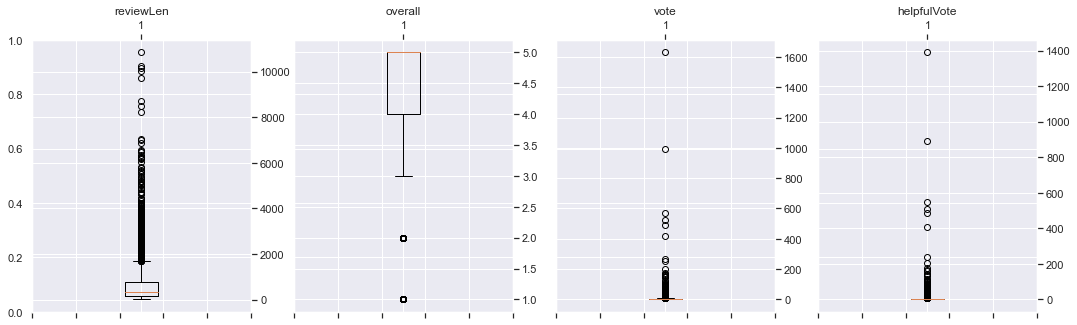

In [22]:
from matplotlib import pyplot as plt

boxplot_col = ['reviewLen','overall','vote','helpfulVote']
fig, axes = plt.subplots(1,4,sharey='row', figsize = (18,5))
for ax,col in zip(axes, boxplot_col):
    ax.set_title(col)
    ax.axes.xaxis.set_ticklabels([])
    new_ax = ax.twiny().twinx()
    new_ax.boxplot(data_corr[col])

Dai boxplot si può evincere come i dati siano generalmente sbilanciati. Per quanto riguarda l'attributo *reviewLen* può essere utile applicare la trasformazione $\phi: x\to\log{x+1}$, $x\in R^n$.

Per quanto riguarda invece l'attributo *overall* si osserva come il dataset sia principalmente sbilanciato, mostrando una maggiore quantità di prodotti valutati con $4$ o $5$ stelle. Può tornare utile un'ulteriore discretizzazione dell'attributo nel seguente modo:
- classe $1$: prodotto valutato buono, contenendo i prodotti valutati con $4$ o $5$ stelle;
- classe $0$: prodotto valutato neutro, contenendo i prodotti valutati con $3$ stelle; 
- classe $-1$: prodotto valutato non buono, contenendo i prodotti valutati con $1$ o $2$ stelle.

Successivamente alla discretizzazione si bilancia il dataset per *label* e *overall*.

Si è osservato dalla matrice di correlazione come gli attributi *vote* ed *helpfulVote* fossero fortemente correlati tra di essi, non portando molta informazione però rispetto ne al rating del prodotto, ne alla categoria di appartenenza. Si costruisce di conseguenza un unico attributo *helpful* indicante la percentuale di utilità della recensione. 

In [23]:
import numpy as np

# trasformazione logaritmica per l'attributo reviewlen
log_len = np.log(data_corr['reviewLen'].to_numpy())

# discretizzazione attributo overall
d_overall = [0]*n_rows
for rate,idx in zip(data_corr['overall'],range(n_rows)):
    if (rate == 1 or rate == 2):
        d_overall[idx] = -1
    elif rate == 3:
        d_overall[idx] = 0
    else: 
        d_overall[idx] = 1
        
# calcolo percentuale di utilità della recensione
helpful = [0]*n_rows
M = np.max(data_corr['vote'])
m = np.min(data_corr['vote'])
for vote,helpfulVote,idx in zip(data_corr['vote'],data_corr['helpfulVote'],range(n_rows)): 
    if vote != 0:
        if helpfulVote == 0:
            helpful[idx] = 0.5*(vote-m)/(M-m)
        else:
            helpful[idx] = helpfulVote/vote

# assegnazione colonne
data_corr['reviewLen'] = log_len
data_corr['overall'] = d_overall
data_corr['helpful'] = helpful

# rimozione colonne e riordinamento
data_corr.drop(columns = ['vote','helpfulVote'], inplace = True)
data_corr = data_corr[['reviewerID','asin', 'reviewLen', 'overall', 'label', 'helpful',
                      'day','month','year','month-year','Date']].copy()
data_corr.head()

reviewerID        asin  reviewLen  overall  label  helpful  day  month  \
0   AH9396O3FGHZF  B000P2A242   6.429719        1      1      0.5   18      6   
1  A39GW5CBWTIWAZ  B000852G2C   7.436617        1      1      0.0    3     11   
2   AW0K56SPCD5XK  B0001F7UHA   6.492240        1      1      0.0   21      6   
3  A2YKADCJME4FSW  B00E5XLZM0   7.635787        1      1      1.0   29     12   
4   AH09XLCE12IO7  B00026WV9U   5.598422        1      1      0.5   15     10   

   year month-year       Date  
0  2007 2007-06-01 2007-06-18  
1  2008 2008-11-01 2008-11-03  
2  2004 2004-06-01 2004-06-21  
3  2013 2013-12-01 2013-12-29  
4  2004 2004-10-01 2004-10-15

Si riapplichino quindi i boxplot per visualizzare i risultati.

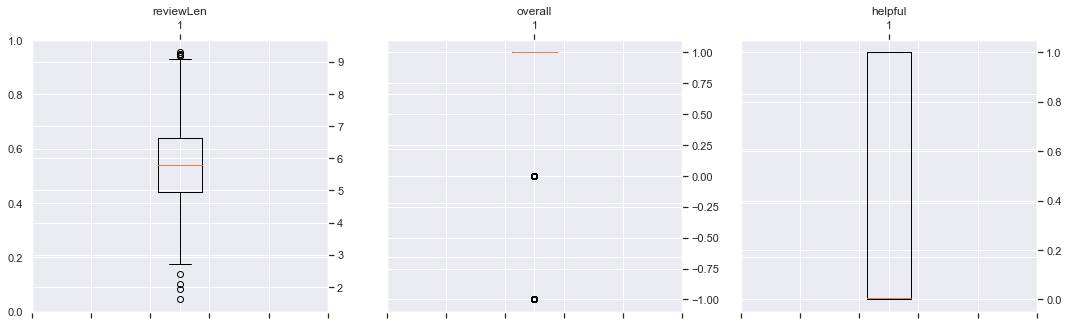

In [24]:
boxplot_col = ['reviewLen','overall','helpful']
fig, axes = plt.subplots(1,3,sharey='row', figsize = (18,5))
for ax,col in zip(axes, boxplot_col):
    ax.set_title(col)
    ax.axes.xaxis.set_ticklabels([])
    new_ax = ax.twiny().twinx()
    new_ax.boxplot(data_corr[col])

La distribuzione dell'attributo *reviewLen* è migliorata notevolmente. *overall* rimane sbilanciato ed *helpful*, sull'intero dataset, risulta poco informativo poiché la maggior parte delle recensioni sembrano essere state poco utili. Si procede quindi con una discretizzazione di quest'ultimo in un attributo categorico $[0,1]$, dove $0$ indica la non utilità e $1$ il viceversa.

Il successivo bilanciamento sarà rispetto a *label*, *overall* ed *helpful*, mantenendo un numero omogeneo di campioni per ciascun attributo. Dopo di che si applicherà un riscalamento tra $[0,1]$ dell'attrobito *reviewLen* e si analizzeranno nuovamente le correlazioni tra gli attributi.

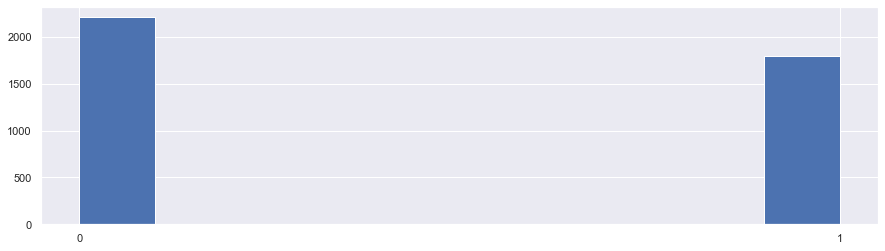

In [25]:
# discretizzazione di helpful: dato il valore medio dei campioni
# vicino allo 0 si tende a includere il valore 0.5 nella classe 1 (utile)
d_helpful = [0]*n_rows
for vote,idx in zip(data_corr['helpful'],range(n_rows)):
    if vote >= 0.5:
        d_helpful[idx] = 1
    else:
        d_helpful[idx] = 0
        
data_corr['helpful'] = d_helpful

plt.figure()
data_corr['helpful'].hist()
plt.xticks(ticks = [0,1], label = [0,1])
plt.show()

Si procede ora con il bilanciamento del dataset.

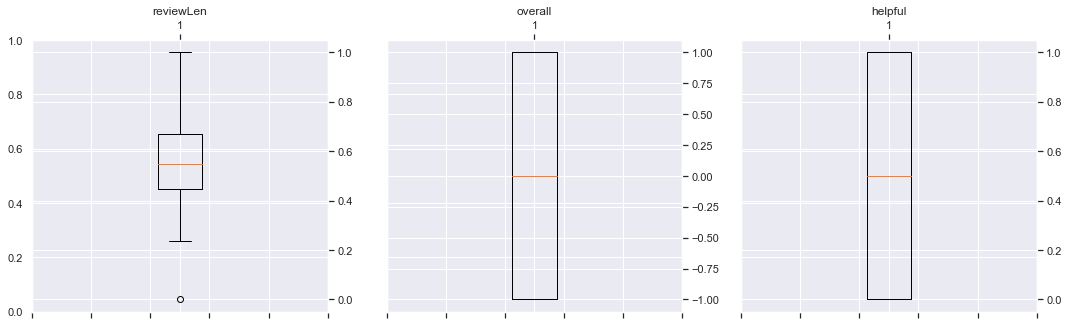

In [26]:
label_values = data_corr['label'].value_counts().index.to_list()
overall_values = data_corr['overall'].value_counts().index.to_list()
helpful_values = data_corr['helpful'].value_counts().index.to_list()

# Cerco la combinazione di valori che presenta meno campioni
n_min = n_rows

for label in label_values:
    for overall in overall_values:
        for helpful in helpful_values:
            cond1 = data_corr['label']==label
            cond2 = data_corr['overall']==overall
            cond3 = data_corr['helpful']==helpful
            n_True = 0
            for i in cond1*cond2*cond3:
                if i == True:
                    n_True += 1
            if n_True < n_min:
                n_min = n_True

# ricostruisco il dataset mantenendo l'uniformità tra classi, 
# campionando randomicamente all'interno del dataset

from sklearn.utils.random import sample_without_replacement

random_state = 0

for label in label_values:
    for overall in overall_values:
        for helpful in helpful_values:
            cond1 = data_corr['label']==label
            cond2 = data_corr['overall']==overall
            cond3 = data_corr['helpful']==helpful
            data_tmp = data_corr.loc[cond1*cond2*cond3,:].copy()
            new_idx = sample_without_replacement(n_population=data_tmp.shape[0],
                                                 n_samples=n_min, random_state = random_state)
            if label==label_values[0] and overall==overall_values[0] and helpful==helpful_values[0]:
                bdata_corr = data_tmp.iloc[new_idx,:].copy()
            else:
                bdata_corr = pd.concat([bdata_corr,data_tmp.iloc[new_idx,:]]).copy()
            random_state+=1

# memorizzo gli indici
indexes = bdata_corr.index

# resetto indici sul dataset per ordine
bn_rows = bdata_corr.shape[0]
bdata_corr.set_index(pd.Index(range(bn_rows)), inplace = True)

# riscalamento in [0,1] dei valori di reviewLen
M = np.max(bdata_corr['reviewLen'])
m = np.min(bdata_corr['reviewLen'])
new_len = [(l-m)/(M-m) for l in bdata_corr['reviewLen']]
bdata_corr['reviewLen'] = new_len

# mostro i boxplot
fig, axes = plt.subplots(1,3,sharey='row', figsize = (18,5))
for ax,col in zip(axes, boxplot_col):
    ax.set_title(col)
    ax.axes.xaxis.set_ticklabels([])
    new_ax = ax.twiny().twinx()
    new_ax.boxplot(bdata_corr[col])

I dati sono stati bilanciati. Si costruisca adesso una nuova matrice di correlazione per il subsample.

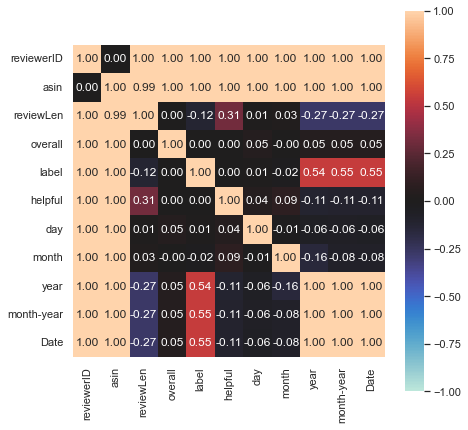

In [27]:
corr_matrix = associations(bdata_corr, figsize=(7,7), plot = False)
bmatrix = corr_matrix['corr']

<AxesSubplot:>

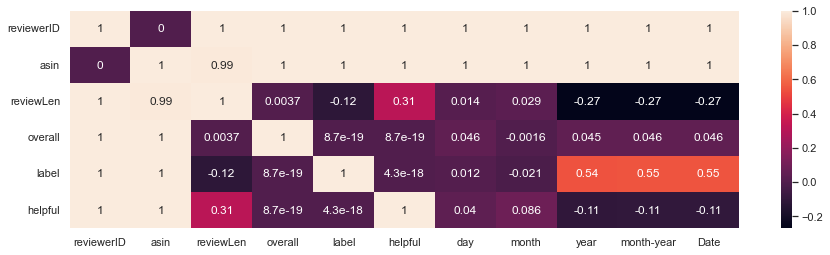

In [28]:
sns.set(rc = {'figure.figsize':(15,4)})
sns.heatmap(bmatrix.iloc[:6,:], annot=True)

Come supposto in precedenza, *reviewerID* e *asin* farebbero overfittare gli algoritmi di machine learning per via della loro corrispondenza 1 a 1 con le recensioni. Interessante invece è la debole correlazione tra *helpful* e *reviewLen* e tra *label* e gli indici temporali.

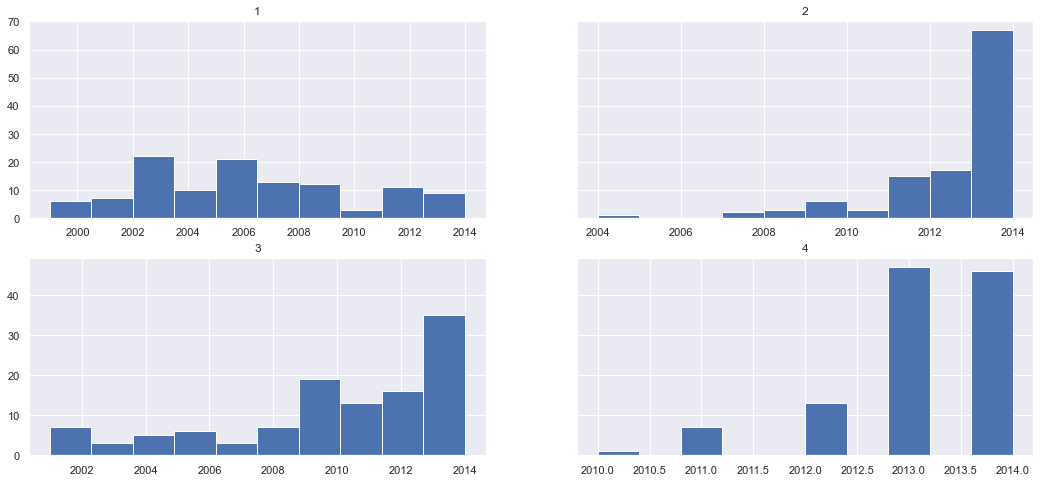

In [29]:
fig, axes = plt.subplots(2,2,sharey='row', figsize = (18,8))
label_values = [[1,2],[3,4]]
for ax_r,labels in zip(axes,label_values):
    for ax,label in zip(ax_r,labels):
        ax.set_title(label)
        ax.hist(bdata_corr['year'][bdata_corr['label']==label])

La correlazione relativa alle date è legata al fatto che in alcuni periodi di tempo non sono state pubblicate recensioni relative ad alcune label.

## Vettorizzazione del testo, key words e clustering

Le analisi verranno condotte sul dataset bilanciato costruito nella sezione precedente. Ogni record è caratterizzato dal testo della recensione e da un riassunto di essa. I riassunti raccolti nell'attributo *summary* tornano utili per ricavare le parole chiave caratterizzanti ciascun gruppo, poiché gli utenti devono, appunto, riassumere il concetto espresso nel testo con poche parole, le quali tendono ad essere parole chiave. 

Le key words per ciascuna *label* si possono identificare tramite la costruzione di un fp-growth, ristretto alla *label* interessata. 

In [30]:
# costruzione dataset con testi
data_txt = data_mod.loc[indexes,['reviewText','summary']].copy()
data_txt['helpful'] = bdata_corr['helpful'].tolist()
data_txt['overall'] = bdata_corr['overall'].tolist()
data_txt['label'] = bdata_corr['label'].tolist()
data_txt.set_index(pd.Index(range(bn_rows)), inplace = True)
data_txt.head()

reviewText  \
0  fireball killer organguitar duel middle no no ...   
1  since rod stewart oftplayed radio opinion many...   
2  one greatest hip hop album ever gza lyric shar...   
3  leaving previous review historical record let ...   
4  album great great great masterpiece metallica ...   

                                summary  helpful  overall  label  
0              wheres robin hood outfit        0        1      1  
1                      best rod stewart        0        1      1  
2                    call genius reason        0        1      1  
3    mc sound updated review star album        0        1      1  
4  opinion metallicas studio album peak        0        1      1

Si procede quindi con la tokenizzazione e separazione per *label* dei *summary*.

In [31]:
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

summary_tok = [None]*bn_rows
for text,idx in zip(data_txt['summary'],range(bn_rows)):
    text_tmp = word_tokenize(text)
    text = [word for word in text_tmp if word not in stop_words]
    summary_tok[idx] = text

# divido i summary per label 
def subset_extraction(text_list,tf_index):
    '''
    text_list: list of tokenized texts
    tf_index: true/false sequence
    '''
    sub_list = []
    for text,idx in zip(text_list,tf_index):
        if idx == True:
            sub_list.append(text)
    return sub_list

split_summary = [None]*4
for label in [1,2,3,4]:
    split_summary[label-1] = subset_extraction(summary_tok,data_txt['label']==label)

È ora possibile costruire l'fp-growth per estrarre le associazioni più frequenti all'interno del dataset.

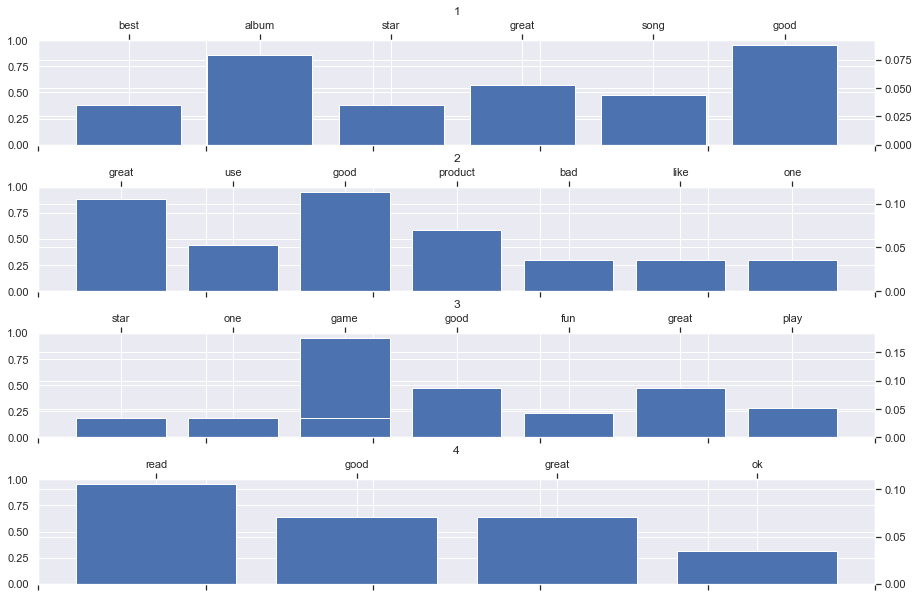

In [32]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

frequent_itemset_fpg = []
for label in [1,2,3,4]:
    encoder = TransactionEncoder()
    enc_array = encoder.fit(split_summary[label-1]).transform(split_summary[label-1])
    enc_df = pd.DataFrame(enc_array, columns=encoder.columns_)
    frequent_itemset_fpg.append(fpgrowth(enc_df, min_support=0.03, use_colnames=True))
    
fig, axes = plt.subplots(4,1,sharey='row', figsize = (15,10))

for ax,idx in zip(axes, [0,1,2,3]):
    ax.set_title(idx+1)
    ax.axes.xaxis.set_ticklabels([])
    new_ax = ax.twiny().twinx()
    new_ax.bar(frequent_itemset_fpg[idx]['itemsets'].apply(lambda x: list(x)[0]).astype("unicode"), 
               frequent_itemset_fpg[idx]['support'])
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

Di seguito i wordcloud per ogni valore di label.

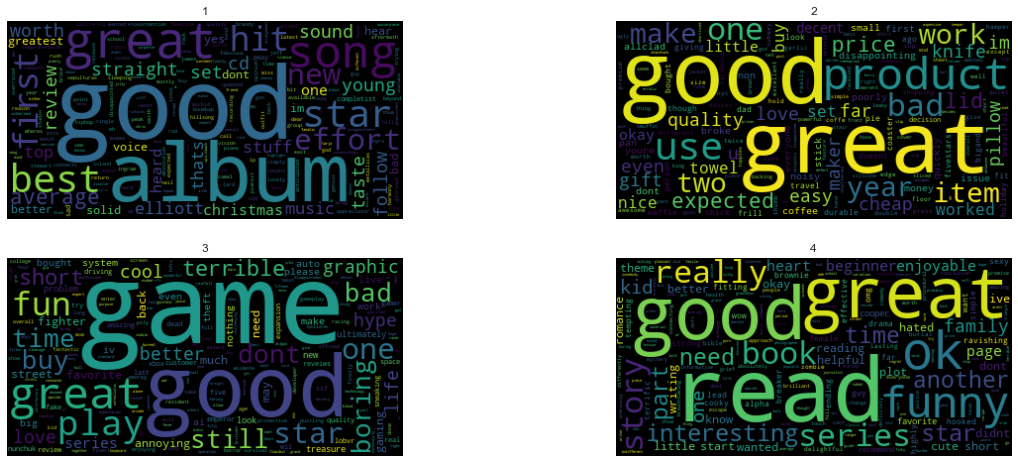

In [33]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

fig, axes = plt.subplots(2,2,sharey='row', figsize = (20,8))
label_values = [[1,2],[3,4]]

for ax_r,labels in zip(axes,label_values): 
    for ax,label in zip(ax_r,labels):
        summary = data_txt.loc[data_txt['label']==label,'summary']
        full_summary = ''
        for text in summary:
            full_summary = full_summary + text + ' '
        ax.set_title(label)
        wordcloud = WordCloud().generate(full_summary)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")

Si generino ora i wordcloud relativi al testo completo delle recensioni e si confrontino con quelli ottenuti nella cella precedente.

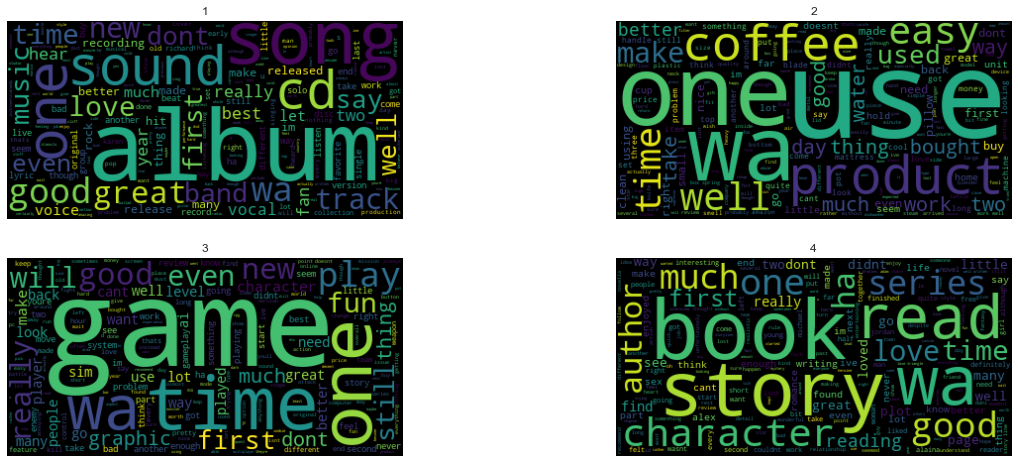

In [34]:
fig, axes = plt.subplots(2,2,sharey='row', figsize = (20,8))
label_values = [[1,2],[3,4]]

for ax_r,labels in zip(axes,label_values): 
    for ax,label in zip(ax_r,labels):
        reviewText = data_txt.loc[data_txt['label']==label,'reviewText']
        full_review = ''
        for text in reviewText:
            full_review = full_review + text + ' '
        ax.set_title(label)
        wordcloud = WordCloud().generate(full_review)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")

Chiaramente quest'ultimi sono più informativi dai primi ottenuti. Il motivo per cui si è scelto precedentemente di utilizzare i *summary* è per rapidità di calcolo nel generare le regole di associazione e verificarne i risultati. In ogni caso, è evidente come ciascuna categoria di recensione sia caratterizzata da alcune parole chiave specifiche per ogni gruppo.

Per completezza di risultati, si applichino gli algoritmi precedenti anche all'attributo *overall* ed *helpful*.

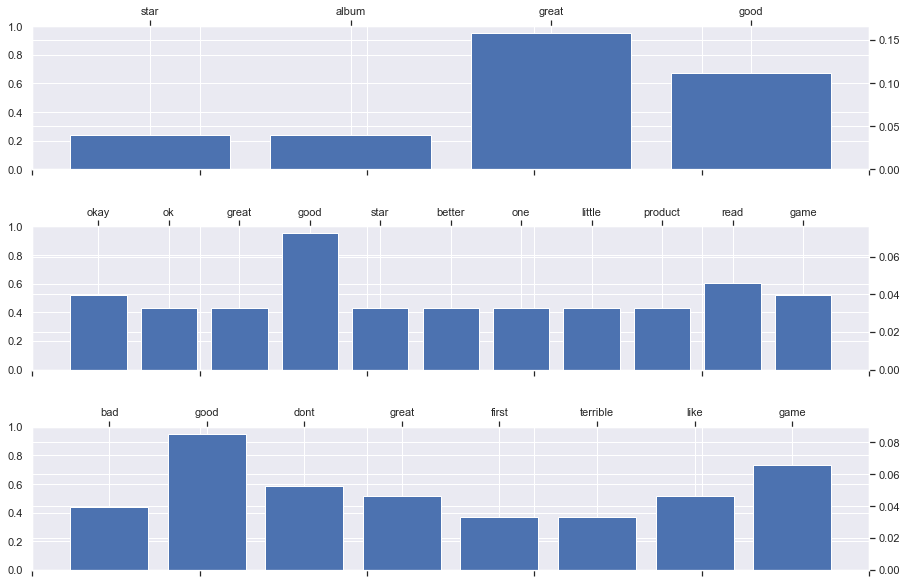

In [35]:
split_overall = [None]*3

for idx,star in zip([0,1,2],[1,0,-1]):
    split_overall[idx] = subset_extraction(summary_tok,data_txt['overall']==star)
    
frequent_itemset_fpg = []
for idx in [0,1,2]:
    encoder = TransactionEncoder()
    enc_array = encoder.fit(split_overall[idx]).transform(split_overall[idx])
    enc_df = pd.DataFrame(enc_array, columns=encoder.columns_)
    frequent_itemset_fpg.append(fpgrowth(enc_df, min_support=0.03, use_colnames=True))
    
fig, axes = plt.subplots(3,1,sharey='row', figsize = (15,10))

for ax,idx in zip(axes, [0,1,2]):
    ax.axes.xaxis.set_ticklabels([])
    new_ax = ax.twiny().twinx()
    new_ax.bar(frequent_itemset_fpg[idx]['itemsets'].apply(lambda x: list(x)[0]).astype("unicode"), 
               frequent_itemset_fpg[idx]['support'])
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

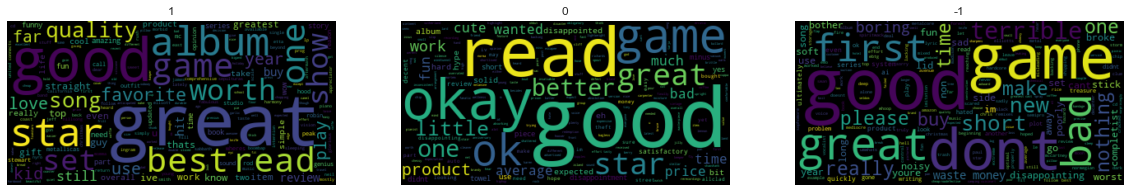

In [36]:
fig, axes = plt.subplots(1,3,sharey='row', figsize = (20,8))

for ax,star in zip(axes,[1,0,-1]): 
    summary = data_txt.loc[data_txt['overall']==star,'summary']
    full_summary = ''
    for text in summary:
        full_summary = full_summary + text + ' '
    ax.set_title(star)
    wordcloud = WordCloud().generate(full_summary)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")

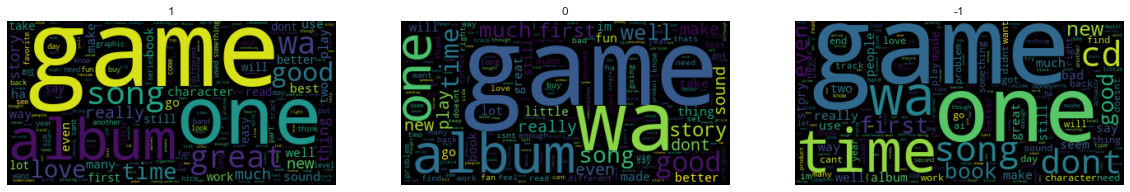

In [37]:
fig, axes = plt.subplots(1,3,sharey='row', figsize = (20,8))

for ax,star in zip(axes,[1,0,-1]): 
    reviewText = data_txt.loc[data_txt['overall']==star,'reviewText']
    full_review = ''
    for text in reviewText:
        full_review = full_review + text + ' '
    ax.set_title(star)
    wordcloud = WordCloud().generate(full_review)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")

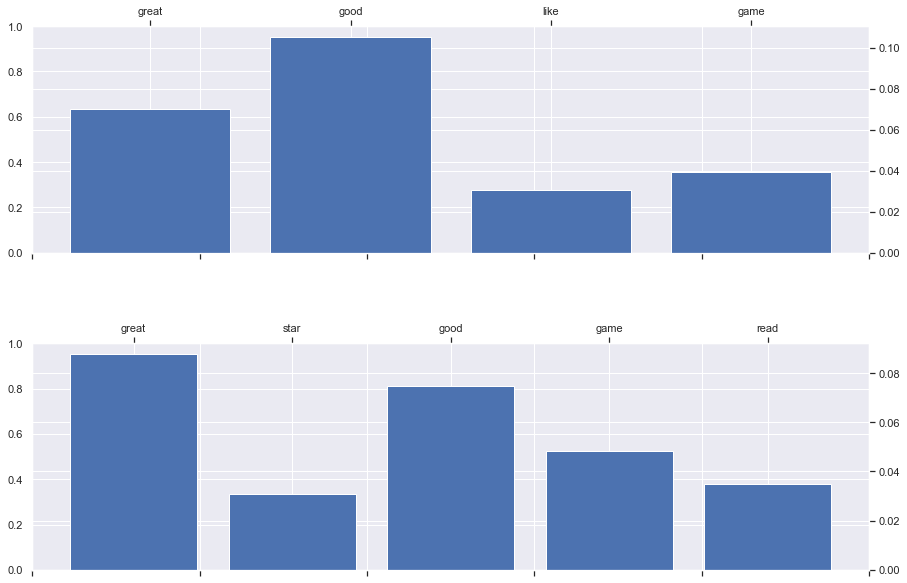

In [38]:
split_helpful = [None]*2

for idx in [0,1]:
    split_helpful[idx] = subset_extraction(summary_tok,data_txt['helpful']==idx)
    
frequent_itemset_fpg = []
for idx in [0,1]:
    encoder = TransactionEncoder()
    enc_array = encoder.fit(split_helpful[idx]).transform(split_helpful[idx])
    enc_df = pd.DataFrame(enc_array, columns=encoder.columns_)
    frequent_itemset_fpg.append(fpgrowth(enc_df, min_support=0.03, use_colnames=True))
    
fig, axes = plt.subplots(2,1,sharey='row', figsize = (15,10))

for ax,idx in zip(axes, [0,1]):
    ax.axes.xaxis.set_ticklabels([])
    new_ax = ax.twiny().twinx()
    new_ax.bar(frequent_itemset_fpg[idx]['itemsets'].apply(lambda x: list(x)[0]).astype("unicode"), 
               frequent_itemset_fpg[idx]['support'])
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

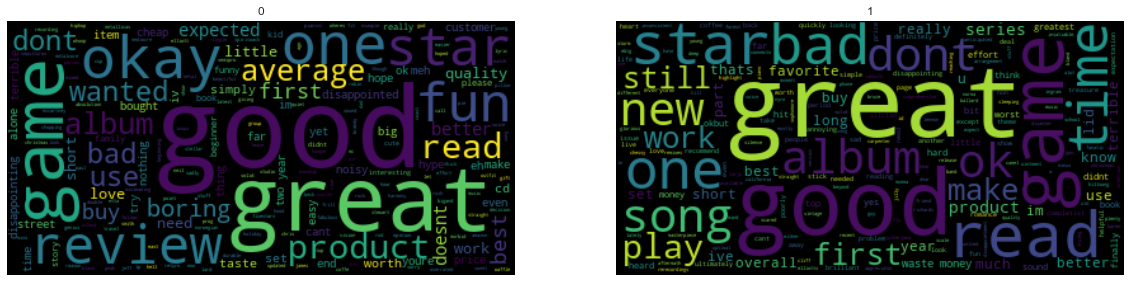

In [39]:
fig, axes = plt.subplots(1,2,sharey='row', figsize = (20,8))

for ax,vote in zip(axes,[0,1]): 
    summary = data_txt.loc[data_txt['helpful']==vote,'summary']
    full_summary = ''
    for text in summary:
        full_summary = full_summary + text + ' '
    ax.set_title(vote)
    wordcloud = WordCloud().generate(full_summary)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")

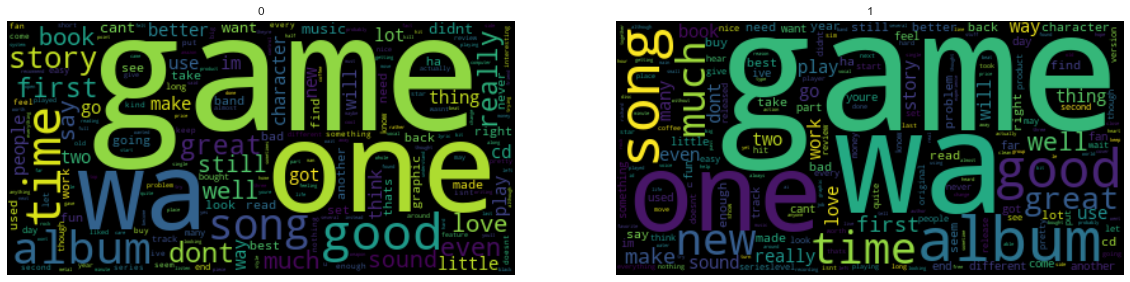

In [40]:
fig, axes = plt.subplots(1,2,sharey='row', figsize = (20,8))

for ax,vote in zip(axes,[0,1]): 
    reviewText = data_txt.loc[data_txt['helpful']==vote,'reviewText']
    full_review = ''
    for text in reviewText:
        full_review = full_review + text + ' '
    ax.set_title(vote)
    wordcloud = WordCloud().generate(full_review)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")

L'attributo *helpful* in generale è risultato essere poco informativo. Tramite regole di associazione e wordcloud si è potuto verificare come entrambe le classi presentassero parole chiavi comune, confermando il risultato ottenuto nell'analisi statistica effettuata nella sezione precedente.

Si elimini quindi l'attributo *overall* dal dataset.

In [41]:
data_txt.drop(columns = 'helpful', inplace = True)

Si testeranno adesso due algoritmi di clustering. In particolare, verranno applicati il DBScan ed il KMeans, misurando il fitting dei raggruppamenti confrontando le metriche silhouette, rand-score ed SSE. Lo scopo è quello di riuscire ad identificare dei cluster relativi alle label e all'overall in funzione del testo della recensione.

In primis è necessario costruire la matrice TF-IDF vettorizzando i testi. In questo modo si assegna un valore numerico a ciascuna parola, la quale risulta essere una coordinata del vettore corrispondente al documente a cui appartiene. Si mostra inoltre la matrice di correlazione delle words, successivamente ad un ordinamento per *label* al fine di rintracciare possibili pattern nella matrice.

<AxesSubplot:>

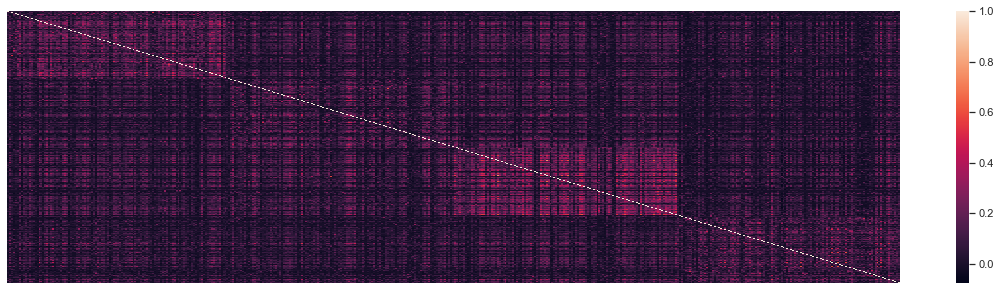

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

# ordinamento per label 
idx_sort = data_txt.sort_values(by = 'label').index.tolist()
sort_txt = data_txt.loc[idx_sort,'reviewText'].copy()
sort_label = data_txt.loc[idx_sort,'label'].copy()

# vettorizzazione dei summary
tfidf = TfidfVectorizer(min_df = 0.03, max_df =0.75, ngram_range = (1,3)).fit_transform(sort_txt.tolist())
word_corr = np.corrcoef(np.array(tfidf.todense()))

# matrice di correlazione
sns.set(rc = {'figure.figsize':(20,5)})
sns.heatmap(word_corr, xticklabels = False, yticklabels = False)

Analogamente si procede con *overall*.

<AxesSubplot:>

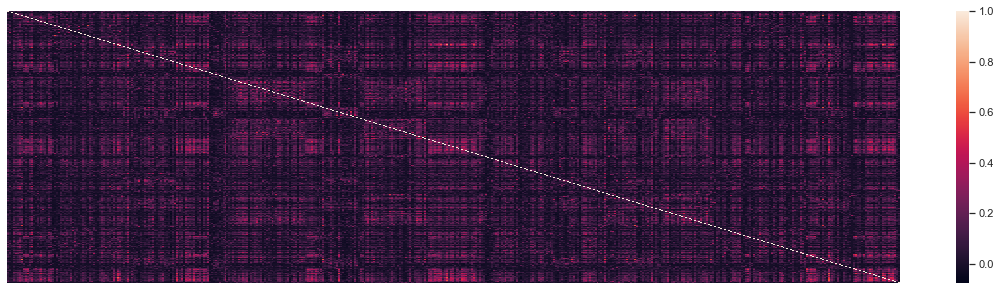

In [43]:
# ordinamento per label 
idx_sort = data_txt.sort_values(by = 'overall').index.tolist()
sort_txt = data_txt.loc[idx_sort,'reviewText'].copy()
sort_overall = data_txt.loc[idx_sort,'overall'].copy()

# vettorizzazione dei summary
tfidf = TfidfVectorizer(min_df = 0.03, max_df =0.75, ngram_range = (1,3)).fit_transform(sort_txt.tolist())
word_corr = np.corrcoef(np.array(tfidf.todense()))

# matrice di correlazione
sns.set(rc = {'figure.figsize':(20,5)})
sns.heatmap(word_corr, xticklabels = False, yticklabels = False)

In entrambi i casi è possibile osservare pattern, ma nel caso relativo alla *label* è evidente come le parole delle recensioni identifichino il tema principale della categoria, differentemente dalla seconda matrice di correlazione dove i pattern sembrano più randomici.

Si applichi ora il KMeans. L'algoritmo verrà testando la ricerca su diversi numeri di clusters. Le prestazioni verranno misurate tramite silhouette, rand score ed SSE.

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, rand_score

# sklearn.metrics non contiene la funzione per calcolare l'SSE, per cui
# lo si calcolerà manualmente
def SSE_score(y_true, y_pred):
    '''
    y_true: classe target della predizione
    y_pred: classe predetta dall'algoritmo
    '''
    return np.sum((y_true-y_pred)**2)

# generazione matrice tfidf
tfidf = TfidfVectorizer(min_df = 0.03, max_df =0.75, ngram_range = (1,3)).fit_transform(data_txt['reviewText'].tolist())

label_clusters = [i for i in range(4,9)] 
overall_clusters = [i for i in range(3,7)]

label_true = data_txt['label'].to_numpy()
overall_true = data_txt['overall'].to_numpy()

silhouette_km_l = []
rand_km_l = []
SSE_km_l = []

for n_clusters in label_clusters:
    label_pred = KMeans(n_clusters = n_clusters,random_state = 7).fit_predict(tfidf,label_true)
    silhouette_km_l.append(silhouette_score(tfidf,label_pred))
    rand_km_l.append(rand_score(label_true,label_pred))
    SSE_km_l.append(SSE_score(label_true,label_pred))

for n_clusters,idx in zip(label_clusters, range(len(label_clusters))):
    print('n_clusters: ', n_clusters, 
          '\nsilhouette_score: ', silhouette_km_l[idx], 
          '\nrand_score: ', rand_km_l[idx],
          '\nSSE_score: ', SSE_km_l[idx],
          '\n')

n_clusters:  4 
silhouette_score:  0.01531603755166286 
rand_score:  0.7291016001542318 
SSE_score:  1811 

n_clusters:  5 
silhouette_score:  0.014870484688979958 
rand_score:  0.7939078465394255 
SSE_score:  621 

n_clusters:  6 
silhouette_score:  0.0161381488579013 
rand_score:  0.783342972816657 
SSE_score:  1680 

n_clusters:  7 
silhouette_score:  0.013933753595884547 
rand_score:  0.7654520917678812 
SSE_score:  2961 

n_clusters:  8 
silhouette_score:  0.00894419982598025 
rand_score:  0.7622325043377675 
SSE_score:  3571 



La silhouette prossima a $0$ ci fa intendere che i cluster sono poco definiti. Il migliore score complessivo è stato raggiunto impostando $5$ cluster, dove si è registrato inoltre l'SSE più basso. Si applichi l'algoritmo all'attributo *overall*.

In [45]:
silhouette_km_o = []
rand_km_o = []
SSE_km_o = []

for n_clusters in overall_clusters:
    overall_pred = KMeans(n_clusters = n_clusters,random_state = 7).fit_predict(tfidf,overall_true)
    silhouette_km_o.append(silhouette_score(tfidf,overall_pred))
    rand_km_o.append(rand_score(overall_true,overall_pred))
    SSE_km_o.append(SSE_score(overall_true,overall_pred))

for n_clusters,idx in zip(overall_clusters, range(len(overall_clusters))):
    print('n_clusters: ', n_clusters, 
          '\nsilhouette_score: ', silhouette_km_o[idx], 
          '\nrand_score: ', rand_km_o[idx],
          '\nSSE_score: ', SSE_km_o[idx],
          '\n')

n_clusters:  3 
silhouette_score:  0.011085646803861574 
rand_score:  0.5426065162907269 
SSE_score:  1056 

n_clusters:  4 
silhouette_score:  0.01531603755166286 
rand_score:  0.5733853865432813 
SSE_score:  2271 

n_clusters:  5 
silhouette_score:  0.014870484688979958 
rand_score:  0.5961634856371698 
SSE_score:  3191 

n_clusters:  6 
silhouette_score:  0.0161381488579013 
rand_score:  0.608502024291498 
SSE_score:  3944 



Come ipotizzato osservando le matrici di correlazione, le parole sono più informative nel caso delle *label*. Silhouette e rand score aumentino con l'aumentare dei cluster, mentre l'SSE, nonostante continui a crescere anch'esso, presenta un incremento decisamente più attenuato.

Di seguito si mostrino i cluster ottenuti con i due algoritmi, confrontati con i cluster originali. Per potere visualizzare i dati, ci si serve della PCA.

Text(0.5, 0, 'PC3')

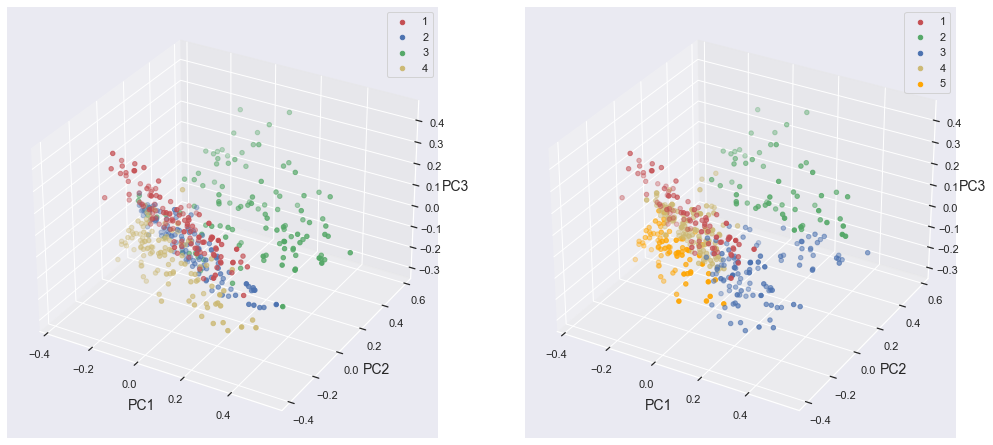

In [46]:
from sklearn.decomposition import PCA

tfidf_label = PCA(n_components = 3).fit_transform(np.array(tfidf.todense()), label_true)
tfidf_overall = PCA(n_components = 3).fit_transform(np.array(tfidf.todense()), overall_true)

label_pred = KMeans(n_clusters = 5, random_state = 7).fit_predict(tfidf,label_true)
overall_pred = KMeans(n_clusters = 6, random_state = 7).fit_predict(tfidf,overall_true)

fig = plt.figure(figsize=(17,17))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
fig.patch.set_facecolor('white')
for i,c in zip([1,2,3,4],['r','b','g','y']):
    x = tfidf_label[label_true==i,:]
    ax1.scatter(x[:,0], x[:,1], x[:,2], c = c)
    ax1.legend([1,2,3,4])
ax1.set_xlabel("PC1", fontsize=14)
ax1.set_ylabel("PC2", fontsize=14)
ax1.set_zlabel("PC3", fontsize=14)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for i,c in zip([0,1,2,3,4],['r','g','b','y','orange']):
    x = tfidf_label[label_pred==i,:]
    ax2.scatter(x[:,0], x[:,1], x[:,2], c = c)
    ax2.legend([1,2,3,4,5])
ax2.set_xlabel("PC1", fontsize=14)
ax2.set_ylabel("PC2", fontsize=14)
ax2.set_zlabel("PC3", fontsize=14)

Text(0.5, 0, 'PC3')

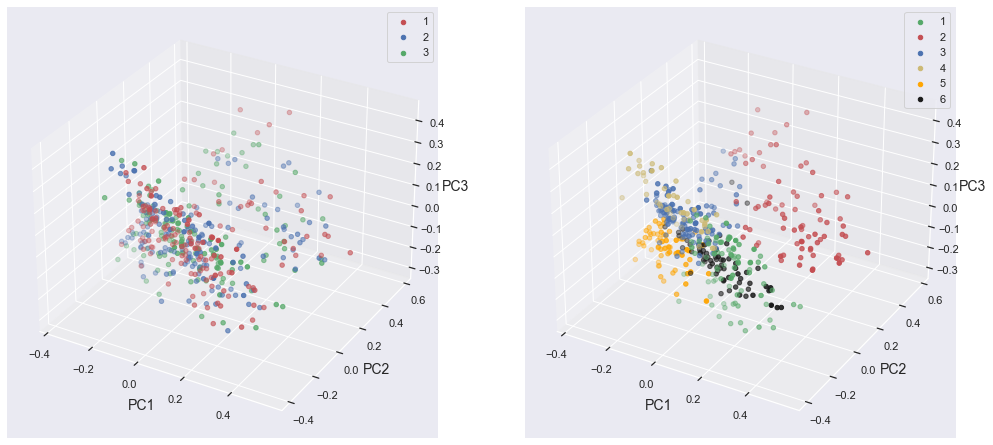

In [47]:
fig = plt.figure(figsize=(17,17))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
fig.patch.set_facecolor('white')
for i,c in zip([1,0,-1],['r','b','g']):
    x = tfidf_overall[overall_true==i,:]
    ax1.scatter(x[:,0], x[:,1], x[:,2], c = c)
    ax1.legend([1,2,3,4])
ax1.set_xlabel("PC1", fontsize=14)
ax1.set_ylabel("PC2", fontsize=14)
ax1.set_zlabel("PC3", fontsize=14)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for i,c in zip([0,1,2,3,4,5],['g','r','b','y','orange','k']):
    x = tfidf_overall[overall_pred==i,:]
    ax2.scatter(x[:,0], x[:,1], x[:,2], c = c)
    ax2.legend([1,2,3,4,5,6])
ax2.set_xlabel("PC1", fontsize=14)
ax2.set_ylabel("PC2", fontsize=14)
ax2.set_zlabel("PC3", fontsize=14)

Si replicano quindi i risultati applicando il DBSCAN.

In [48]:
from sklearn.cluster import DBSCAN

silhouette_dbs_l = []
rand_dbs_l = []
SSE_dbs_l = []

eps_values = [1+i*0.04 for i in range(1,6)]

for eps in eps_values:
    label_pred = DBSCAN(eps = eps,n_jobs = -1).fit(tfidf,label_true).labels_
    silhouette_dbs_l.append(silhouette_score(tfidf,label_pred))
    rand_dbs_l.append(rand_score(label_true,label_pred))
    SSE_dbs_l.append(SSE_score(label_true,label_pred))

for eps,idx in zip(eps_values, range(len(eps_values))):
    print('eps_values: ', eps, 
          '\nsilhouette_score: ', silhouette_dbs_l[idx], 
          '\nrand_score: ', rand_dbs_l[idx],
          '\nSSE_score: ', SSE_dbs_l[idx],
          '\n')

eps_values:  1.04 
silhouette_score:  0.0033945971479551764 
rand_score:  0.4626951995373048 
SSE_score:  5434 

eps_values:  1.08 
silhouette_score:  0.006714846630908021 
rand_score:  0.5086080586080586 
SSE_score:  5117 

eps_values:  1.12 
silhouette_score:  0.017212065148277503 
rand_score:  0.534384037015616 
SSE_score:  4763 

eps_values:  1.16 
silhouette_score:  0.027717680381769475 
rand_score:  0.4722190090611143 
SSE_score:  4264 

eps_values:  1.2 
silhouette_score:  0.03230381639625012 
rand_score:  0.35960092539039906 
SSE_score:  3759 



In [49]:
silhouette_dbs_o = []
rand_dbs_o = []
SSE_dbs_o = []

eps_values = [1+i*0.04 for i in range(1,6)]

for eps in eps_values:
    overall_pred = DBSCAN(eps = eps,n_jobs = -1).fit(tfidf,overall_true).labels_
    silhouette_dbs_o.append(silhouette_score(tfidf,overall_pred))
    rand_dbs_o.append(rand_score(overall_true,overall_pred))
    SSE_dbs_o.append(SSE_score(overall_true,overall_pred))

for eps,idx in zip(eps_values, range(len(eps_values))):
    print('eps_values: ', eps, 
          '\nsilhouette_score: ', silhouette_dbs_o[idx], 
          '\nrand_score: ', rand_dbs_o[idx],
          '\nSSE_score: ', SSE_dbs_o[idx],
          '\n')

eps_values:  1.04 
silhouette_score:  0.0033945971479551764 
rand_score:  0.4637748216695585 
SSE_score:  618 

eps_values:  1.08 
silhouette_score:  0.006714846630908021 
rand_score:  0.4913533834586466 
SSE_score:  591 

eps_values:  1.12 
silhouette_score:  0.017212065148277503 
rand_score:  0.5046558704453441 
SSE_score:  543 

eps_values:  1.16 
silhouette_score:  0.027717680381769475 
rand_score:  0.4699055330634278 
SSE_score:  452 

eps_values:  1.2 
silhouette_score:  0.03230381639625012 
rand_score:  0.4008579140158087 
SSE_score:  349 



Come ci si poteva aspettare, il DBSCAN ha ottenuto degli score peggiori rispetto al KMeans. Questo perché, già osservando la silhouette del KMeans i clusters risultano essere molto vicini, per cui il DBSCAN ottiene scarsi risultati. Si procederà quindi studiando la solidità del KMeans, con la sua configurazione ottimale, rispetto alla label al variare dei dati che gli vengono forniti.

In [50]:
from sklearn.model_selection import StratifiedShuffleSplit

sks = StratifiedShuffleSplit(n_splits=10, train_size = 0.25, random_state = 42)

silhouette_km_l = []
rand_km_l = []
SSE_km_l = []

for split_indexes, tmp in sks.split(data_mod['reviewText'], data_corr['label']):
    txt_tmp = data_mod.loc[split_indexes,'reviewText']
    label_tmp = data_mod.loc[split_indexes,'label']
    tfidf_tmp = TfidfVectorizer(min_df = 0.03, max_df =0.75, 
                                ngram_range = (1,3)).fit_transform(txt_tmp.tolist())

    label_pred = KMeans(n_clusters = 5,random_state = 7).fit_predict(tfidf_tmp,label_tmp)
    silhouette_km_l.append(silhouette_score(tfidf_tmp,label_pred))
    rand_km_l.append(rand_score(label_tmp,label_pred))
    SSE_km_l.append(SSE_score(label_tmp,label_pred))
    
index = ["sample {}".format(i+1) for i in range(10)]
index.append('mean_scores')
columns = ['silhouette_score','rand_score','SSE_score']
silhouette_km_l.append(np.mean(silhouette_km_l))
rand_km_l.append(np.mean(rand_km_l))
SSE_km_l.append(np.mean(SSE_km_l))

results = pd.DataFrame(np.array([silhouette_km_l, rand_km_l, SSE_km_l]).T,
                      index = index, columns = columns)

results

silhouette_score  rand_score  SSE_score
sample 1             0.017087    0.749305     3611.0
sample 2             0.012921    0.773359     4094.0
sample 3             0.018377    0.757359     2685.0
sample 4             0.013413    0.743802     4997.0
sample 5             0.016439    0.746280     1904.0
sample 6             0.015482    0.749690     4305.0
sample 7             0.019909    0.755143     2642.0
sample 8             0.012764    0.766697     2064.0
sample 9             0.015717    0.767846     1787.0
sample 10            0.012188    0.745592     2204.0
mean_scores          0.015430    0.755507     3029.3

Come si è potuto osservare dal test precedente, il comportamento del KMeans rimane stabile nonostante il cambiamento dei dati forniti. Si possono ulteriormente migliorare le prestazioni applicando LDA per separare al meglio i dati e ridurne la dimensionalità.

Text(0.5, 0, 'lda_component 3')

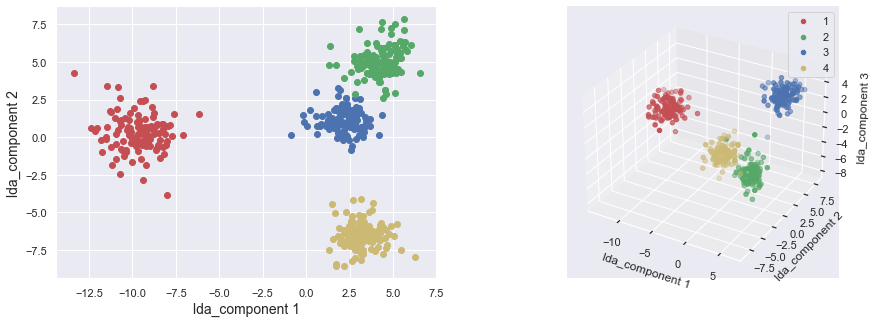

In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

x_lda = LDA().fit_transform(np.array(tfidf.todense()), label_true)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 2, 1)
for i,c in zip([1,2,3,4],['r','b','g','y']):
    x = x_lda[label_true==i,:]
    ax1.scatter(x[:,0],x[:,1],c=c)
ax1.set_xlabel("lda_component 1", fontsize=14)
ax1.set_ylabel("lda_component 2", fontsize=14)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for i,c in zip([1,2,3,4],['r','g','b','y']):
    x = x_lda[label_true==i,:]
    ax2.scatter(x[:,0], x[:,1], x[:,2], c = c)
    ax2.legend([1,2,3,4,5,6])
ax2.set_xlabel("lda_component 1", fontsize=12)
ax2.set_ylabel("lda_component 2", fontsize=12)
ax2.set_zlabel("lda_component 3", fontsize=12)

Vista l'ottima separazione ottenuta tramite LDA, si testi ora il KNN ed il DBSCAN sul dataset bilanciato.

In [52]:
silhouette_km_l = []
rand_km_l = []
SSE_km_l = []

label_clusters = [3,4,5,6]

for n_clusters in label_clusters:
    label_pred = KMeans(n_clusters = n_clusters,random_state = 7).fit_predict(x_lda,label_true)
    silhouette_km_l.append(silhouette_score(x_lda,label_pred))
    rand_km_l.append(rand_score(label_true,label_pred))
    SSE_km_l.append(SSE_score(label_true,label_pred))

for n_clusters,idx in zip(label_clusters, range(len(label_clusters))):
    print('n_clusters: ', n_clusters, 
          '\nsilhouette_score: ', silhouette_km_l[idx], 
          '\nrand_score: ', rand_km_l[idx],
          '\nSSE_score: ', SSE_km_l[idx],
          '\n')

n_clusters:  3 
silhouette_score:  0.6395401985760679 
rand_score:  0.8747252747252747 
SSE_score:  1938 

n_clusters:  4 
silhouette_score:  0.7957537930925187 
rand_score:  0.9978118372855215 
SSE_score:  692 

n_clusters:  5 
silhouette_score:  0.6537693375529571 
rand_score:  0.9681222286485445 
SSE_score:  1088 

n_clusters:  6 
silhouette_score:  0.5214534488840037 
rand_score:  0.935733564680933 
SSE_score:  2864 



In [53]:
silhouette_dbs_l = []
rand_dbs_l = []
SSE_dbs_l = []

eps_values = [1 + 0.1*i for i in range(11)]

for eps in eps_values:
    label_pred = DBSCAN(eps = eps,n_jobs = -1).fit(x_lda,label_true).labels_
    silhouette_dbs_l.append(silhouette_score(x_lda,label_pred))
    rand_dbs_l.append(rand_score(label_true,label_pred))
    SSE_dbs_l.append(SSE_score(label_true,label_pred))

for eps,idx in zip(eps_values, range(len(eps_values))):
    print('eps_values: ', eps, 
          '\nsilhouette_score: ', silhouette_dbs_l[idx], 
          '\nrand_score: ', rand_dbs_l[idx],
          '\nSSE_score: ', SSE_dbs_l[idx],
          '\n')

eps_values:  1.0 
silhouette_score:  0.6401186819056596 
rand_score:  0.9400906111432428 
SSE_score:  1042 

eps_values:  1.1 
silhouette_score:  0.681949653263646 
rand_score:  0.95686331212647 
SSE_score:  881 

eps_values:  1.2 
silhouette_score:  0.6992460060827572 
rand_score:  0.963977250819356 
SSE_score:  815 

eps_values:  1.3 
silhouette_score:  0.7303443600025046 
rand_score:  0.9778581068054752 
SSE_score:  663 

eps_values:  1.4 
silhouette_score:  0.7477904756671467 
rand_score:  0.984509350298824 
SSE_score:  600 

eps_values:  1.5 
silhouette_score:  0.7551436640205793 
rand_score:  0.9890206284943127 
SSE_score:  550 

eps_values:  1.6 
silhouette_score:  0.770948775613595 
rand_score:  0.9922594948910738 
SSE_score:  541 

eps_values:  1.7000000000000002 
silhouette_score:  0.770948775613595 
rand_score:  0.9922594948910738 
SSE_score:  541 

eps_values:  1.8 
silhouette_score:  0.7740106038489398 
rand_score:  0.9933776749566223 
SSE_score:  538 

eps_values:  1.9 
s

Le performance degli algoritmi sono notevolmente migliorate con la separazione costruita tramite l'LDA. Si riapplichino i risultati per quanto riguarda il rating assegnato in *overall*.

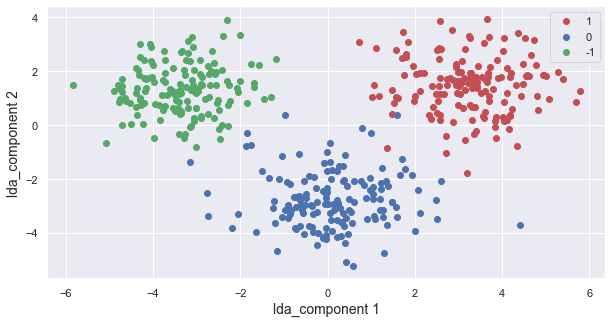

In [54]:
x_lda = LDA().fit_transform(np.array(tfidf.todense()), overall_true)

plt.figure(figsize=(10,5))
for i,c in zip([1,0,-1],['r','b','g']):
    x = x_lda[overall_true==i,:]
    plt.scatter(x[:,0],x[:,1],c=c)
plt.xlabel("lda_component 1", fontsize=14)
plt.ylabel("lda_component 2", fontsize=14)
plt.legend([1,0,-1])
plt.show()

In [55]:
silhouette_km_o = []
rand_km_o = []
SSE_km_o = []

overall_clusters = [2,3,4]

for n_clusters in overall_clusters:
    overall_pred = KMeans(n_clusters = n_clusters,random_state = 7).fit_predict(x_lda,overall_true)
    silhouette_km_o.append(silhouette_score(x_lda,overall_pred))
    rand_km_o.append(rand_score(overall_true,overall_pred))
    SSE_km_o.append(SSE_score(overall_true,overall_pred))

for n_clusters,idx in zip(overall_clusters, range(len(overall_clusters))):
    print('n_clusters: ', n_clusters, 
          '\nsilhouette_score: ', silhouette_km_o[idx], 
          '\nrand_score: ', rand_km_o[idx],
          '\nSSE_score: ', SSE_km_o[idx],
          '\n')

n_clusters:  2 
silhouette_score:  0.5040377125331663 
rand_score:  0.763601310969732 
SSE_score:  294 

n_clusters:  3 
silhouette_score:  0.6620502105095395 
rand_score:  0.9770291112396375 
SSE_score:  1391 

n_clusters:  4 
silhouette_score:  0.5491697297571895 
rand_score:  0.9282340466550992 
SSE_score:  1581 



In [56]:
silhouette_dbs_o = []
rand_dbs_o = []
SSE_dbs_o = []

eps_values = [0.4 + 0.1*i for i in range(6)]

for eps in eps_values:
    overall_pred = DBSCAN(eps = eps,n_jobs = -1).fit(x_lda,overall_true).labels_
    silhouette_dbs_o.append(silhouette_score(x_lda,overall_pred))
    rand_dbs_o.append(rand_score(overall_true,overall_pred))
    SSE_dbs_o.append(SSE_score(overall_true,overall_pred))

for eps,idx in zip(eps_values, range(len(eps_values))):
    print('eps_values: ', eps, 
          '\nsilhouette_score: ', silhouette_dbs_o[idx], 
          '\nrand_score: ', rand_dbs_o[idx],
          '\nSSE_score: ', SSE_dbs_o[idx],
          '\n')

eps_values:  0.4 
silhouette_score:  0.34098383324833237 
rand_score:  0.8445344129554656 
SSE_score:  4620 

eps_values:  0.5 
silhouette_score:  0.4381604898120765 
rand_score:  0.9162618083670715 
SSE_score:  2984 

eps_values:  0.6000000000000001 
silhouette_score:  0.5783647924544334 
rand_score:  0.9383555041449778 
SSE_score:  1625 

eps_values:  0.7000000000000001 
silhouette_score:  0.6043260683493231 
rand_score:  0.954973973395026 
SSE_score:  1646 

eps_values:  0.8 
silhouette_score:  0.6020342503505112 
rand_score:  0.9626084441873916 
SSE_score:  1675 

eps_values:  0.9 
silhouette_score:  0.402254694803721 
rand_score:  0.764517061885483 
SSE_score:  903 



## Classificazione

Terminata l'analisi dati si vogliono testare degli algoritmi di classificazione al fine di predire il voto che un utente può dare al prodotto in base alla propria recensione. Questa applicazione può tornare utile nel momento in cui un utente recensisce un prodotto non assegnando un rate di gradimento. Predire questo rate permette di arrichire l'analisi dati nel caso fossero presenti missing values e per valutare il sentiment di una recensione. 
Allo stesso modo si applicheranno gli algoritmi per la previsione della label. 
Gli algoritmi scelti per questo task sono l'SVM con kernel lineare e la regressione logistica.

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

X = data_txt['reviewText']
y = data_txt['overall']

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

best_logreg = {'multi_class':None,'C':None,'f1_score':0}
best_svc = {'loss':None,'C':None,'f1_score':0}

multi_class_params = ['ovr','multinomial']
loss_params = ['hinge', 'squared_hinge']
C_params = [0.25,0.5,0.75,1]

for C in C_params:
    for multi_class,loss in zip(multi_class_params,loss_params):
        svc_f1 = []
        logreg_f1 = []
        for train_idx, test_idx in skf.split(X,y):
            vectorizer = TfidfVectorizer(min_df = 0.03, max_df =0.75, ngram_range = (1,3)).fit(X[train_idx].tolist())
            X_train = vectorizer.transform(X[train_idx].tolist())
            X_test = vectorizer.transform(X[test_idx].tolist())
            y_train = y[train_idx]
            y_test = y[test_idx]
            svc = LinearSVC(loss = loss, C = C, random_state = 42).fit(X_train,y_train)
            logreg = LogisticRegression(multi_class = multi_class, C = C,
                                        max_iter = 1000, n_jobs = -1, random_state = 42).fit(X_train,y_train)
            svc_f1.append(f1_score(y_test, svc.predict(X_test),average = 'macro'))
            logreg_f1.append(f1_score(y_test, logreg.predict(X_test),average = 'macro'))
        svc_f1_tmp = np.sum(svc_f1)/(len(svc_f1))
        lr_f1_tmp = np.sum(logreg_f1)/(len(logreg_f1))
        if svc_f1_tmp > best_svc['f1_score']:
            best_svc['f1_score'] = svc_f1_tmp
            best_svc['loss'] = loss
            best_svc['C'] = C
        if lr_f1_tmp > best_logreg['f1_score']:
            best_logreg['f1_score'] = lr_f1_tmp
            best_logreg['multi_class'] = multi_class
            best_logreg['C'] = C
            
print('best_svc: ', best_svc,
     '\nbest_logreg: ', best_logreg)

best_svc:  {'loss': 'squared_hinge', 'C': 0.25, 'f1_score': 0.5031683359226078} 
best_logreg:  {'multi_class': 'multinomial', 'C': 1, 'f1_score': 0.4954218970882881}


In [58]:
X = data_txt['reviewText']
y = data_txt['label']

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

best_logreg = {'multi_class':None,'C':None,'f1_score':0}
best_svc = {'loss':None,'C':None,'f1_score':0}

multi_class_params = ['ovr','multinomial']
loss_params = ['hinge', 'squared_hinge']
C_params = [0.25,0.5,0.75,1]

for C in C_params:
    for multi_class,loss in zip(multi_class_params,loss_params):
        svc_f1 = []
        logreg_f1 = []
        for train_idx, test_idx in skf.split(X,y):
            vectorizer = TfidfVectorizer(min_df = 0.03, max_df =0.75, ngram_range = (1,3)).fit(X[train_idx].tolist())
            X_train = vectorizer.transform(X[train_idx].tolist())
            X_test = vectorizer.transform(X[test_idx].tolist())
            y_train = y[train_idx]
            y_test = y[test_idx]
            svc = LinearSVC(loss = loss, C = C, random_state = 42).fit(X_train,y_train)
            logreg = LogisticRegression(multi_class = multi_class, C = C,
                                        max_iter = 1000, n_jobs = -1, random_state = 42).fit(X_train,y_train)
            svc_f1.append(f1_score(y_test, svc.predict(X_test),average = 'macro'))
            logreg_f1.append(f1_score(y_test, logreg.predict(X_test),average = 'macro'))
        svc_f1_tmp = np.sum(svc_f1)/(len(svc_f1))
        lr_f1_tmp = np.sum(logreg_f1)/(len(logreg_f1))
        if svc_f1_tmp > best_svc['f1_score']:
            best_svc['f1_score'] = svc_f1_tmp
            best_svc['loss'] = loss
            best_svc['C'] = C
        if lr_f1_tmp > best_logreg['f1_score']:
            best_logreg['f1_score'] = lr_f1_tmp
            best_logreg['multi_class'] = multi_class
            best_logreg['C'] = C
            
print('best_svc: ', best_svc,
     '\nbest_logreg: ', best_logreg)

best_svc:  {'loss': 'hinge', 'C': 0.25, 'f1_score': 0.9339187587190783} 
best_logreg:  {'multi_class': 'multinomial', 'C': 0.5, 'f1_score': 0.9304478819608836}


I classificatori sembrano performare meglio nella previsione della label. Le migliori combinazioni verranno applicate per predire l'overall e la label sull'intero dataset.

In [59]:
data_test = data_mod[~data_corr.index.isin(indexes)].copy()

X_test = data_test['reviewText']
overall_test = data_corr[~data_corr.index.isin(indexes)]['overall'].copy()
label_test = data_test['label']

X_train = data_txt['reviewText']
overall_train = data_txt['overall']
label_train = data_txt['label']

vectorizer = TfidfVectorizer(min_df = 0.03, max_df =0.75, ngram_range = (1,3)).fit(X_train.tolist())
X_train = vectorizer.transform(X_train.tolist())
X_test = vectorizer.transform(X_test.tolist())

svc_ov = LinearSVC(loss = 'squared_hinge', C = 0.25, random_state = 42).fit(X_train,overall_train)
logreg_ov = LogisticRegression(multi_class = 'multinomial', C = 1,
                               max_iter = 1000, n_jobs = -1, random_state = 42).fit(X_train,overall_train)

svc_lb = LinearSVC(loss = 'hinge', C = 0.25, random_state = 42).fit(X_train,label_train)
logreg_lb = LogisticRegression(multi_class = 'multinomial', C = 0.5,
                               max_iter = 1000, n_jobs = -1, random_state = 42).fit(X_train,label_train)

overall_score = {'svc': f1_score(overall_test, svc_ov.predict(X_test),average = 'macro'),
                'logreg': f1_score(overall_test, logreg_ov.predict(X_test),average = 'macro')}
label_score = {'svc': f1_score(label_test, svc_lb.predict(X_test),average = 'macro'),
                'logreg': f1_score(label_test, logreg_lb.predict(X_test),average = 'macro')}

print('overall results:\n',overall_score,
     '\nlabel results:\n',label_score)

overall results:
 {'svc': 0.3643675949841261, 'logreg': 0.360156631335472} 
label results:
 {'svc': 0.9139765701548854, 'logreg': 0.9108429105113914}


In definitiva, le performance riguardo le predizioni rispetto al rating del prodotto sono risultate scarse. In compenso, gli algoritmi hanno mostrato una certa robustezza per quanto riguarda la previsione della label. 